<a href="https://colab.research.google.com/github/AdityaKr015/CIFAR-10-CNN-vs-GNN/blob/main/CIFAR_10_CNN_vs_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CIFAR-10 CNN vs GNN**

This Project is made By Aditya Kumar, Viabhav Kumar Kanojia and Utkarsh Tripathi with Assistance from Mr.Mo Ahsan Ahmed Sir.


**Objective**
- Train CIFAR-10 on both CNN and GNN
- Compare both of it in terms of Accurucy,Precision,F1 score,Recall,Confusion matrix etc.
- Show actual vs predicted results with help of images

**Imports important libraries**

In [ ]:
import torch, torchvision, numpy, torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.segmentation import slic
from sklearn import metrics
from skimage.segmentation import slic

**CIFAR-10 Dataset Loading and Preprocessing**

 In this step, torchvision.datasets is used to load the CIFAR-10 dataset.
 To guarantee that every image is in an appropriate format for training, we use fundamental preprocessing techniques:

 Every image is transformed from a PIL image to a PyTorch tensor using ToTensor().

 By scaling pixel values to the interval [-1, 1], normalize() enhances model convergence and stabilizes training.

 CIFAR-10 automatically divides the dataset into 10,000 test images and 50,000 training images.

 Later on in the project, this dataset will serve as the input for the CNN and GNN models.

In [ ]:
# Basic transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Training dataset (50k)
train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

# Test dataset (10k)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)


100%|██████████| 170M/170M [00:17<00:00, 9.75MB/s]


**Splits the datset in 70/15/15**
 70% for training,15% each for test and validation

In [ ]:
total_train = len(full_train_dataset)

train_size = int(0.70 * total_train)
val_size = int(0.15 * total_train)
extra_test_size = total_train - train_size - val_size

train_set, val_set, extra_test_set = random_split(
    full_train_dataset, [train_size, val_size, extra_test_size]
)


library installation

In [ ]:
!pip install torch-scatter torch-sparse torch-geometric -f https://data.pyg.org/whl/torch-2.2.0+cu118.html
!pip install scikit-image

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 123.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.4 MB/s eta 0:00:00


**Data Augmentation for Training**

To improve model generalization, we apply data augmentation on the CIFAR-10 training images.

Random cropping, flipping, and color jittering introduce natural variations, while normalization standardizes the input.

The test set uses only normalization to ensure fair evaluation.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Train dataset with augmentation
full_train_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)

# Test dataset (no augmentation)
test_dataset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)



**Importing Libraries and Checking GPU Availability**

Imported all required libraries for data processing, model building, and training.
This cell also checks if a CUDA-enabled GPU (like T4) is available, which significantly speeds up CNN and GNN training.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


**Creating DataLoaders for Training, Validation, and Testing**

We wrap the dataset splits into PyTorch DataLoaders.
These loaders handle batching, shuffling, and efficient data feeding during training and evaluation.
Batch size is set to 128 for faster and more stable training.

In [ ]:
batch_size = 128

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



**Defining the CNN Architecture**

This block defines our Convolutional Neural Network.
The model uses two convolutional blocks with ReLU activation, max-pooling, and dropout, followed by fully connected layers for classification.
This architecture extracts spatial features from CIFAR-10 images and maps them to 10 output classes.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CNN().to(device)


**Loss Function, Optimizer, and Learning Rate Scheduler**

We use CrossEntropyLoss for multi-class classification.
The Adam optimizer updates model weights efficiently, and a ReduceLROnPlateau scheduler automatically lowers the learning rate when validation loss stops improving, helping the CNN converge more smoothly.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


**Training the CNN Model (with Validation Monitoring)**

This loop trains the CNN for 50 epochs.
For each epoch, we compute training loss/accuracy and evaluate on the validation set.
The learning-rate scheduler adjusts the LR when validation loss stops improving, helping stabilize convergence.
Training and validation metrics are stored for later plotting and comparison.

In [ ]:
epochs = 50
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    model.train()
    train_correct = 0
    train_total = 0
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Validation
    val_correct = 0
    val_total = 0
    val_loss_epoch = 0
    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_epoch += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss_epoch / len(val_loader))
    train_accs.append(100 * train_correct / train_total)
    val_accs.append(100 * val_correct / val_total)

    scheduler.step(val_losses[-1])   # <-- important line

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} "
          f"Train Acc: {train_accs[-1]:.2f}% | Val Acc: {val_accs[-1]:.2f}%")


Epoch [1/50] Train Loss: 1.9203 | Val Loss: 1.6504 Train Acc: 28.12% | Val Acc: 39.53%
Epoch [2/50] Train Loss: 1.6062 | Val Loss: 1.4361 Train Acc: 40.66% | Val Acc: 46.68%
Epoch [3/50] Train Loss: 1.4721 | Val Loss: 1.3070 Train Acc: 46.25% | Val Acc: 51.99%
Epoch [4/50] Train Loss: 1.3877 | Val Loss: 1.2569 Train Acc: 49.40% | Val Acc: 54.76%
Epoch [5/50] Train Loss: 1.3130 | Val Loss: 1.1946 Train Acc: 52.39% | Val Acc: 55.85%
Epoch [6/50] Train Loss: 1.2638 | Val Loss: 1.1271 Train Acc: 54.88% | Val Acc: 59.17%
Epoch [7/50] Train Loss: 1.2242 | Val Loss: 1.0823 Train Acc: 56.30% | Val Acc: 60.77%
Epoch [8/50] Train Loss: 1.1849 | Val Loss: 1.0868 Train Acc: 57.44% | Val Acc: 60.41%
Epoch [9/50] Train Loss: 1.1342 | Val Loss: 1.0087 Train Acc: 59.82% | Val Acc: 63.27%
Epoch [10/50] Train Loss: 1.1067 | Val Loss: 0.9918 Train Acc: 60.56% | Val Acc: 64.59%
Epoch [11/50] Train Loss: 1.0783 | Val Loss: 0.9315 Train Acc: 62.13% | Val Acc: 66.68%
Epoch [12/50] Train Loss: 1.0531 | Val Lo

**Plotting Training vs Validation Performance**

These plots help visualize how the CNN learns over time.
The loss curves show convergence behavior, while the accuracy curves reveal how well the model generalizes to the validation set.

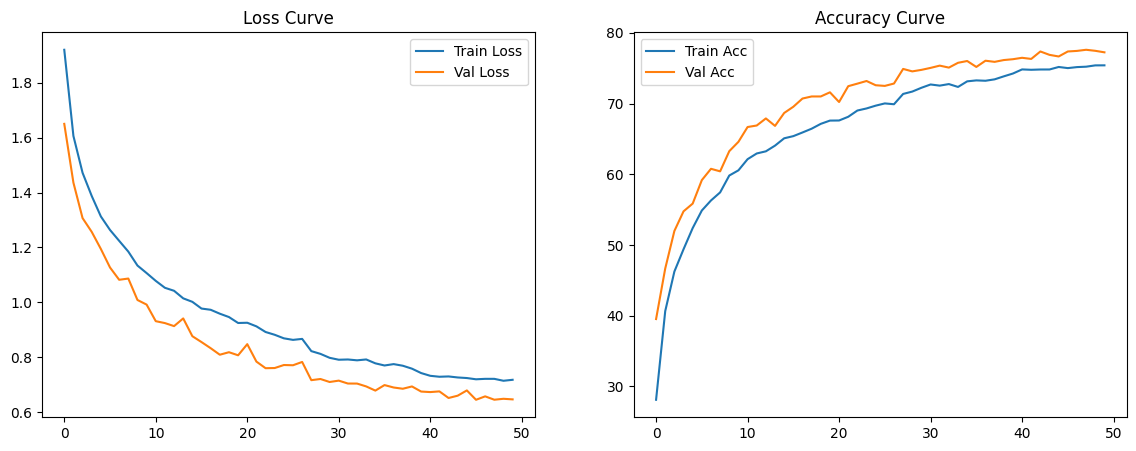

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()


**Evaluating the CNN on Train, Validation, and Test Sets**

We define a reusable evaluate() function that computes loss and accuracy for any dataset split.
Using this, we report the CNN’s performance on the training, validation, and test sets in a clean, Keras-style format.

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = 100 * correct / total
    return avg_loss, avg_acc

train_loss, train_acc = evaluate(model, train_loader, criterion)
val_loss, val_acc = evaluate(model, val_loader, criterion)
test_loss, test_acc = evaluate(model, test_loader, criterion)

print(f"Training  - Accuracy: {train_acc:.2f}%, Loss: {train_loss:.4f}")
print(f"Validation- Accuracy: {val_acc:.2f}%, Loss: {val_loss:.4f}")
print(f"Testing   - Accuracy: {test_acc:.2f}%, Loss: {test_loss:.4f}")


Training  - Accuracy: 80.88%, Loss: 0.5442
Validation- Accuracy: 77.40%, Loss: 0.6480
Testing   - Accuracy: 79.57%, Loss: 0.5884


**Visualizing CNN Predictions on Test Images**

We take a batch of images from the test set and show the model’s predictions alongside the actual labels.
This helps visually confirm how well the CNN is recognizing different CIFAR-10 classes.

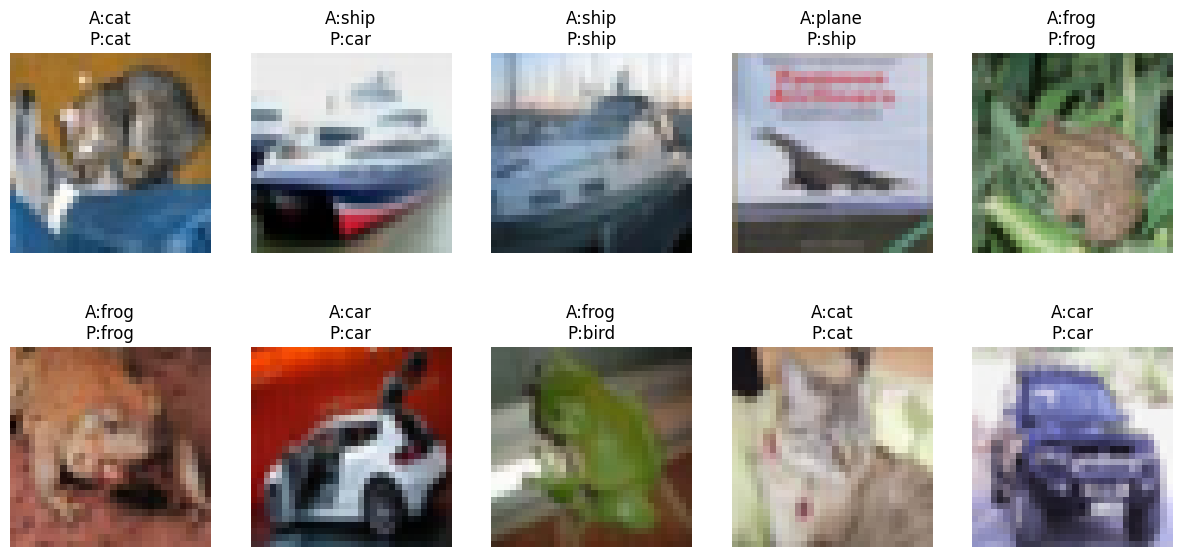

In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

images_gpu = images.to(device)

outputs = model(images_gpu)
_, predicted = outputs.cpu().max(1)

plt.figure(figsize=(15,7))

for i in range(10):
    plt.subplot(2,5,i+1)
    img = images[i] / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.title(f"A:{classes[labels[i]]}\nP:{classes[predicted[i]]}")
    plt.axis('off')

plt.show()

**Computing CNN Evaluation Metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)**

In this step, we evaluate the CNN using standard classification metrics.
We collect predictions for the entire test set and calculate accuracy, precision, recall, and F1 score.
A full classification report and confusion matrix are also generated to understand class-wise performance.

CNN Accuracy: 0.7957
CNN Precision: 0.795646110081049
CNN Recall: 0.7957
CNN F1 Score: 0.7946689177905474

CNN Classification Report:

              precision    recall  f1-score   support

       plane       0.82      0.79      0.80      1000
         car       0.94      0.90      0.92      1000
        bird       0.66      0.70      0.68      1000
         cat       0.67      0.59      0.63      1000
        deer       0.76      0.77      0.76      1000
         dog       0.75      0.69      0.72      1000
        frog       0.77      0.87      0.82      1000
       horse       0.87      0.81      0.84      1000
        ship       0.88      0.91      0.89      1000
       truck       0.86      0.92      0.89      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.79     10000
weighted avg       0.80      0.80      0.79     10000



<Axes: >

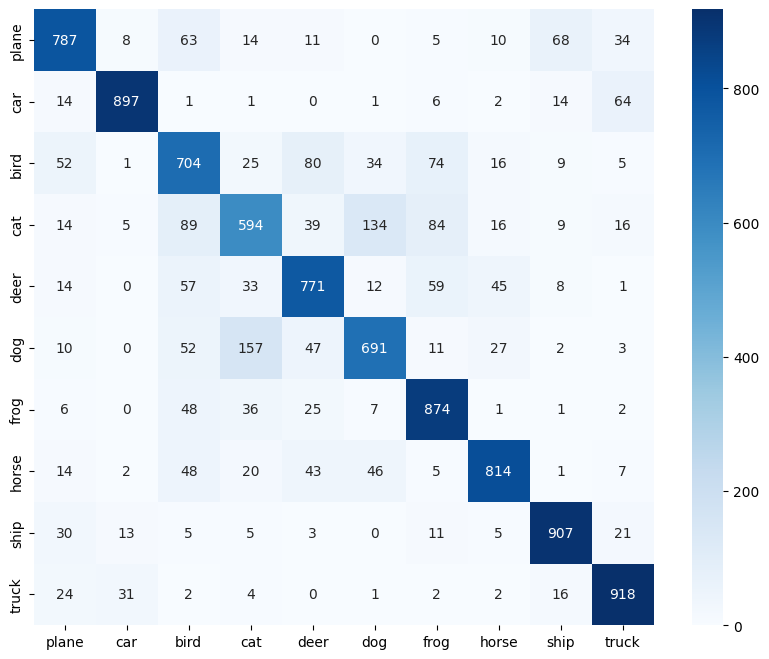

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Collect predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Convert to numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy
cnn_accuracy = accuracy_score(all_labels, all_preds)
print("CNN Accuracy:", cnn_accuracy)

# Precision, Recall, F1
prec, rec, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
print("CNN Precision:", prec)
print("CNN Recall:", rec)
print("CNN F1 Score:", f1)

# Full classification report
print("\nCNN Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))


# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=classes,
    yticklabels=classes
)


**Visualizing Learned CNN Filters**

This plot shows the filters learned by the first convolutional layer.
Each filter acts as a pattern detector (edges, textures, color blobs), and visualizing them helps us understand what low-level features the CNN extracts from the CIFAR-10 images during training.

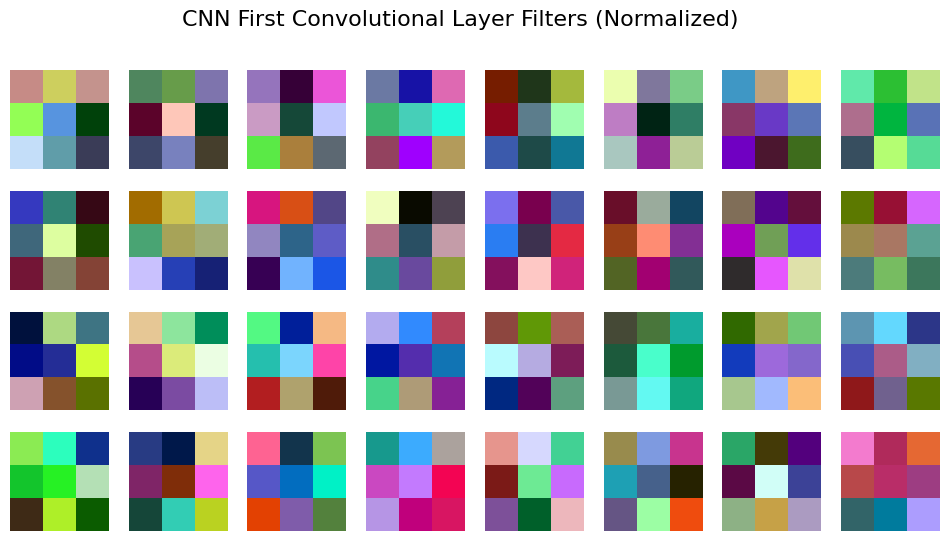

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

first_conv = model.features[0].weight.data.cpu()

fig = plt.figure(figsize=(12, 6))
for i in range(32):
    ax = fig.add_subplot(4, 8, i+1)

    filt = first_conv[i].permute(1,2,0).numpy()

    # Normalize to 0–1
    f_min, f_max = filt.min(), filt.max()
    filt_norm = (filt - f_min) / (f_max - f_min + 1e-5)

    ax.imshow(filt_norm)
    ax.axis("off")

plt.suptitle("CNN First Convolutional Layer Filters (Normalized)", fontsize=16)
plt.show()


**Converting CIFAR-10 Images into Superpixel Graphs (for GNN Input)**

This function transforms a CIFAR-10 image into a graph representation.
We first undo normalization, apply the SLIC superpixel algorithm, and treat each superpixel as a node with features (RGB + position).
Edges are created between neighboring superpixels, forming a graph structure suitable for GNN processing.

In [ ]:
import torch
import numpy as np
from skimage.segmentation import slic
from torch_geometric.data import Data

def image_to_graph(image, segments=75):
    # UNNORMALIZE image before SLIC
    img = image.clone()
    img = img * 0.5 + 0.5      # convert back to [0,1]
    img = img.permute(1, 2, 0).numpy()

    # Step 1: superpixels
    sp = slic(img, n_segments=segments, compactness=10, start_label=0)

    num_nodes = sp.max() + 1

    # Node features
    node_feats = []
    for i in range(num_nodes):
        mask = (sp == i)
        pixels = img[mask]

        if len(pixels) == 0:
            pixels = np.zeros((1,3))

        mean_rgb = pixels.mean(axis=0)
        coords = np.column_stack(np.where(mask)).mean(axis=0)

        node_feats.append(np.concatenate((mean_rgb, coords)))

    x = torch.tensor(node_feats, dtype=torch.float)

    # Step 2: edges
    edges = set()
    H, W, _ = img.shape

    for y in range(H - 1):
        for x_pix in range(W - 1):
            a = sp[y, x_pix]
            b = sp[y+1, x_pix]
            c = sp[y, x_pix+1]

            if a != b:
                edges.add((a, b))
                edges.add((b, a))
            if a != c:
                edges.add((a, c))
                edges.add((c, a))

    edge_index = torch.tensor(list(edges), dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)
    return data


/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_sparse/_version_cuda.so
  import torch_geometric.typing


**Testing the Image-to-Graph Conversion**

We take one sample image from the dataset and convert it into a graph using our image_to_graph() function.
This helps verify that the superpixel segmentation and graph construction are working correctly and returning a valid PyTorch Geometric Data object.

In [ ]:
sample_img, sample_label = train_dataset[0]
graph = image_to_graph(sample_img)

print(graph)


Data(x=[56, 5], edge_index=[2, 280])


/tmp/ipython-input-2232198213.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  x = torch.tensor(node_feats, dtype=torch.float)


**Creating a Custom Graph Dataset for GNN Training**

We define a custom GraphDataset class that converts every CIFAR-10 image into a graph using our image_to_graph() function.
Each graph stores its node features, edges, and label, allowing us to use PyTorch Geometric’s DataLoader for efficient GNN training.

In [ ]:
from torch_geometric.data import InMemoryDataset

class GraphDataset(InMemoryDataset):
    def __init__(self, image_dataset, transform=None):
        super(GraphDataset, self).__init__()
        self.image_dataset = image_dataset
        self.transform = transform

        self.data_list = []
        for img, label in self.image_dataset:
            graph = image_to_graph(img)
            graph.y = torch.tensor([label], dtype=torch.long)
            self.data_list.append(graph)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]


**Converting All Dataset Splits Into Graph Format**

We now convert the training, validation, and test splits into graph datasets using the GraphDataset class.
Each CIFAR-10 image is transformed into a graph of superpixels, so the GNN can be trained and evaluated on graph-structured data instead of raw images.

In [ ]:
graph_train = GraphDataset(train_set)
graph_val = GraphDataset(val_set)
graph_test = GraphDataset(test_dataset)


**Creating Graph DataLoaders for GNN Training**

We wrap the graph-based datasets into PyTorch Geometric DataLoaders.
These loaders handle batching of graph samples and are used during training, validation, and testing of the GNN.

In [ ]:
from torch_geometric.loader import DataLoader as GraphLoader

train_gloader = GraphLoader(graph_train, batch_size=64, shuffle=True)
val_gloader = GraphLoader(graph_val, batch_size=64, shuffle=False)
test_gloader = GraphLoader(graph_test, batch_size=64, shuffle=False)


**Defining the GNN Architecture (Graph Convolutional Network)**

This model processes each image in graph form using three GCNConv layers with batch normalization and ReLU activation.
After message passing across the graph nodes, we apply global mean pooling to obtain a graph-level embedding, followed by fully connected layers for classification into 10 CIFAR-10 classes.

In [ ]:
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

class GNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Input = 5 features → (R,G,B,X,Y)
        self.conv1 = GCNConv(5, 64)
        self.bn1 = BatchNorm(64)

        self.conv2 = GCNConv(64, 128)
        self.bn2 = BatchNorm(128)

        self.conv3 = GCNConv(128, 128)
        self.bn3 = BatchNorm(128)

        self.fc1 = nn.Linear(128, 128)
        self.drop = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = torch.relu(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = torch.relu(x)

        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = torch.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x


**Setting Up Loss, Optimizer, and Scheduler for the GNN**

We use CrossEntropyLoss for classification and the Adam optimizer to update the GNN parameters.
A ReduceLROnPlateau scheduler lowers the learning rate automatically when validation loss stops improving, helping the model converge more reliably.

In [ ]:
model_gnn = GNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_gnn.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)


**Training the GNN Model (with Validation Monitoring)**

This loop trains the GNN for 60 epochs.
Each epoch performs message passing on graph batches, computes training loss/accuracy, and evaluates on the validation set.
The learning rate scheduler adjusts the LR when validation loss plateaus.
All metrics are logged for plotting and comparison with CNN performance.

In [ ]:
epochs = 60
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

optimizer = torch.optim.Adam(
    model_gnn.parameters(),
    lr=0.001,
    weight_decay=5e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

for epoch in range(epochs):
    model_gnn.train()
    train_correct = 0
    total_train = 0
    running_loss = 0

    # TRAIN
    for batch in train_gloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        out = model_gnn(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = out.max(1)
        total_train += batch.y.size(0)
        train_correct += pred.eq(batch.y).sum().item()

    # VALIDATION
    model_gnn.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for batch in val_gloader:
            batch = batch.to(device)
            out = model_gnn(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            val_loss += loss.item()

            _, pred = out.max(1)
            total_val += batch.y.size(0)
            val_correct += pred.eq(batch.y).sum().item()

    avg_train_loss = running_loss / len(train_gloader)
    avg_val_loss = val_loss / len(val_gloader)
    train_acc = 100 * train_correct / total_train
    val_acc = 100 * val_correct / total_val

    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")


Epoch [1/60] Train Loss: 2.0468 | Val Loss: 2.0480 Train Acc: 22.27% | Val Acc: 23.69%
Epoch [2/60] Train Loss: 1.9147 | Val Loss: 2.1417 Train Acc: 28.35% | Val Acc: 21.67%
Epoch [3/60] Train Loss: 1.8786 | Val Loss: 2.3401 Train Acc: 30.57% | Val Acc: 19.61%
Epoch [4/60] Train Loss: 1.8559 | Val Loss: 2.0470 Train Acc: 31.69% | Val Acc: 25.92%
Epoch [5/60] Train Loss: 1.8341 | Val Loss: 1.8891 Train Acc: 32.46% | Val Acc: 29.60%
Epoch [6/60] Train Loss: 1.8204 | Val Loss: 1.8599 Train Acc: 33.20% | Val Acc: 31.68%
Epoch [7/60] Train Loss: 1.8108 | Val Loss: 1.8568 Train Acc: 33.68% | Val Acc: 30.39%
Epoch [8/60] Train Loss: 1.8003 | Val Loss: 1.8972 Train Acc: 33.91% | Val Acc: 30.33%
Epoch [9/60] Train Loss: 1.7913 | Val Loss: 1.8867 Train Acc: 34.50% | Val Acc: 31.43%
Epoch [10/60] Train Loss: 1.7844 | Val Loss: 1.8491 Train Acc: 34.59% | Val Acc: 30.80%
Epoch [11/60] Train Loss: 1.7729 | Val Loss: 1.8818 Train Acc: 35.17% | Val Acc: 30.61%
Epoch [12/60] Train Loss: 1.7665 | Val Lo

**Evaluating the GNN on the Test Set**

We run the trained GNN on the test graph dataset and measure its final classification accuracy.
This gives us a direct performance comparison with the CNN on the same CIFAR-10 test set.

In [ ]:
model_gnn.eval()
correct = 0
total = 0

with torch.no_grad():
    for batch in test_gloader:
        batch = batch.to(device)
        out = model_gnn(batch.x, batch.edge_index, batch.batch)
        _, pred = out.max(1)
        total += batch.y.size(0)
        correct += pred.eq(batch.y).sum().item()

print(f"GNN Test Accuracy: {100 * correct / total:.2f}%")


GNN Test Accuracy: 43.02%


**Plotting GNN Training vs Validation Performance**

These curves show how the GNN learns over time.
The loss plot reflects training stability, while the accuracy plot helps visualize generalization to the validation set—useful for comparing GNN learning behavior with the CNN.

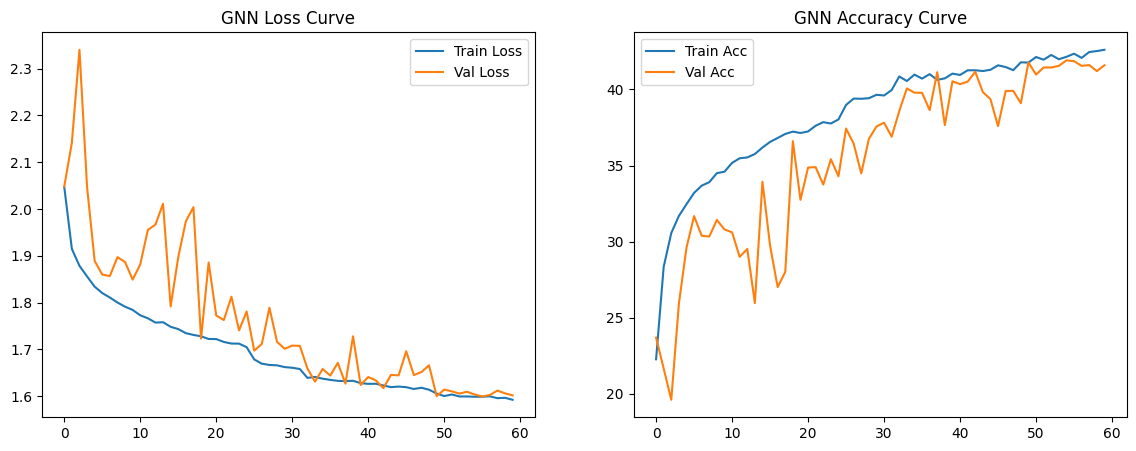

In [ ]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("GNN Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("GNN Accuracy Curve")

plt.show()


Visualizing GNN Predictions on Test Images
**bold text**
We randomly pick test images, convert each into a superpixel graph, and pass them through the trained GNN.
The actual and predicted labels are shown below each image, allowing us to visually assess how well the GNN understands CIFAR-10 samples.

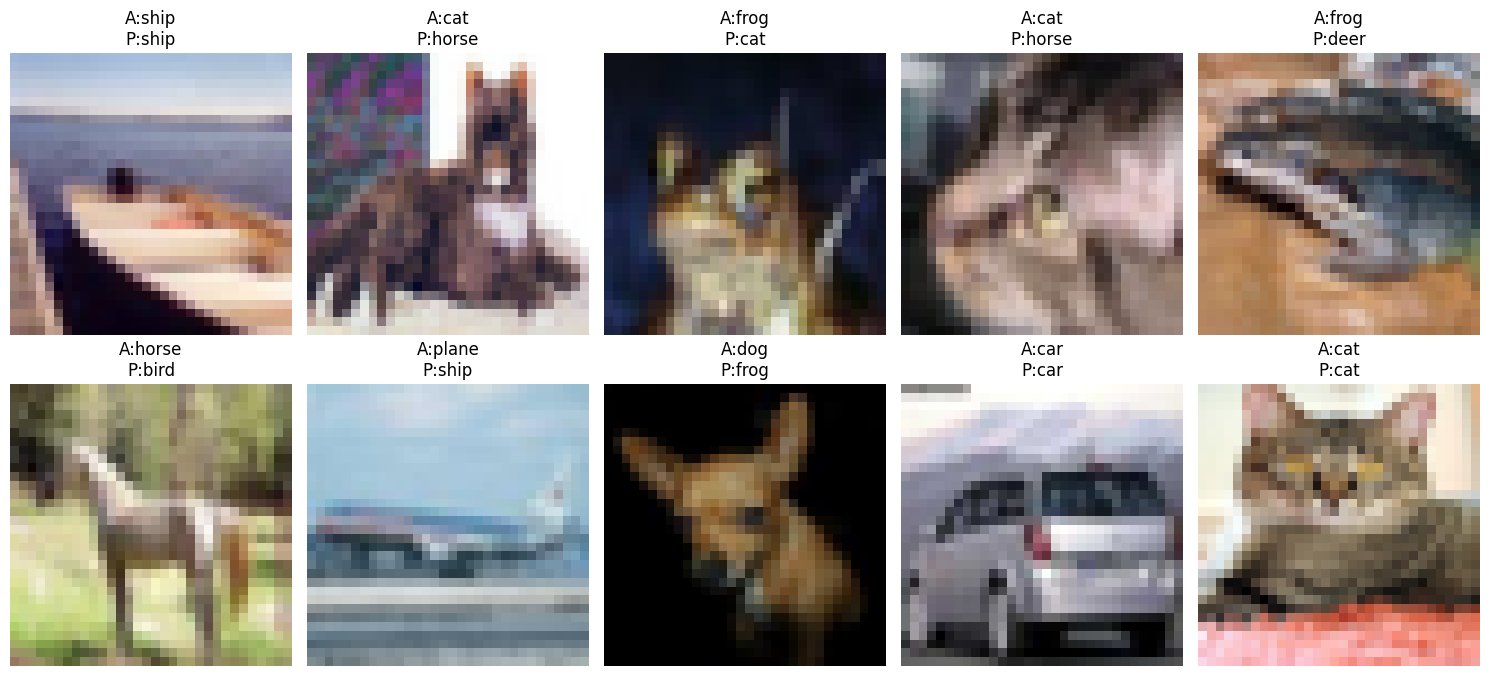

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def unnormalize(img):
    return (img * 0.5 + 0.5).numpy()

model_gnn.eval()

fig = plt.figure(figsize=(15, 7))

# Display 8 images (2 rows x 4 columns)
for i in range(10):
    idx = random.randint(0, len(test_dataset)-1)

    img, label = test_dataset[idx]

    # Build graph for each image
    graph = image_to_graph(img)
    graph.y = torch.tensor([label])
    graph = graph.to(device)

    # Predict
    with torch.no_grad():
        out = model_gnn(graph.x, graph.edge_index,
                        torch.zeros(graph.x.size(0), dtype=torch.long).to(device))
        _, pred = out.max(1)

    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(np.transpose(unnormalize(img), (1, 2, 0)))
    ax.set_title(f"A:{classes[label]}\nP:{classes[pred.item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


**Computing GNN Evaluation Metrics (Accuracy, Precision, Recall, F1, Confusion Matrix)**

We evaluate the GNN on the full test set using standard classification metrics.
This includes accuracy, macro-averaged precision/recall/F1, a detailed classification report, and a confusion matrix.
These results allow us to directly compare GNN performance with the CNN on all CIFAR-10 classes.

GNN Accuracy: 0.4302
GNN Precision (macro): 0.4506200724392911
GNN Recall (macro): 0.43019999999999997
GNN F1 Score (macro): 0.42677377626860585

GNN Classification Report:

              precision    recall  f1-score   support

       plane       0.40      0.66      0.50      1000
         car       0.60      0.43      0.50      1000
        bird       0.28      0.44      0.34      1000
         cat       0.34      0.30      0.32      1000
        deer       0.36      0.32      0.34      1000
         dog       0.47      0.20      0.28      1000
        frog       0.53      0.40      0.45      1000
       horse       0.43      0.51      0.47      1000
        ship       0.60      0.53      0.57      1000
       truck       0.50      0.51      0.50      1000

    accuracy                           0.43     10000
   macro avg       0.45      0.43      0.43     10000
weighted avg       0.45      0.43      0.43     10000



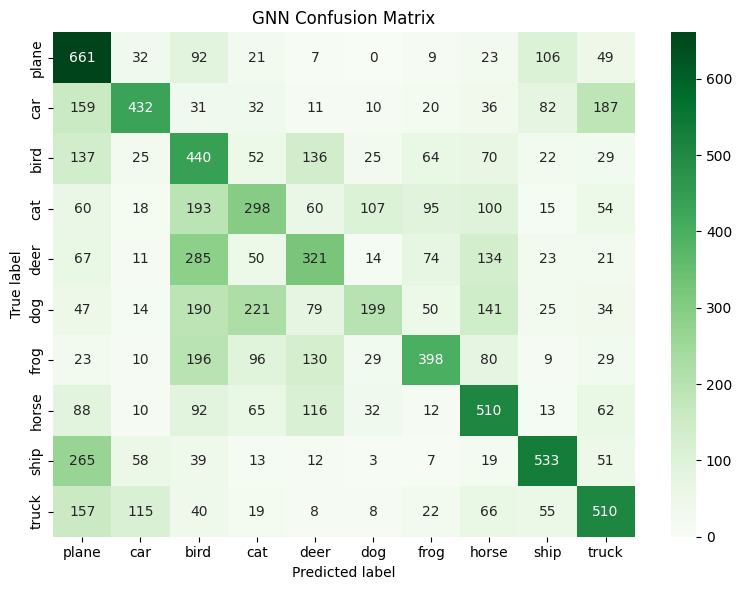

In [ ]:
 # Colab usually does this by default
# import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import sklearn


from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

model_gnn.eval()

all_preds_gnn = []
all_labels_gnn = []

with torch.no_grad():
    for batch in test_gloader:
        batch = batch.to(device)
        out = model_gnn(batch.x, batch.edge_index, batch.batch)
        _, preds = out.max(1)

        all_preds_gnn.extend(preds.cpu().numpy())
        all_labels_gnn.extend(batch.y.cpu().numpy())

all_preds_gnn = np.array(all_preds_gnn)
all_labels_gnn = np.array(all_labels_gnn)

# Put your real class names here, in index order
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Accuracy
gnn_accuracy = accuracy_score(all_labels_gnn, all_preds_gnn)
print("GNN Accuracy:", gnn_accuracy)

# Precision, Recall, F1 (macro)
prec_g, rec_g, f1_g, _ = precision_recall_fscore_support(
    all_labels_gnn,
    all_preds_gnn,
    average='macro',
    zero_division=0
)
print(f"GNN Precision (macro): {prec_g}")
print(f"GNN Recall (macro): {rec_g}")
print(f"GNN F1 Score (macro): {f1_g}")

# Full classification report
print("\nGNN Classification Report:\n")
# print(classification_report(
#     all_labels_gnn,
#     all_preds_gnn,
#     target_names=classes,
#     zero_division=0
# ))
print(
    classification_report(
        all_labels_gnn,
        all_preds_gnn,
        target_names=classes,
        zero_division=0
    )
)


# Confusion Matrix
cm = confusion_matrix(all_labels_gnn, all_preds_gnn)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=classes,
    yticklabels=classes
)
plt.title("GNN Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


**Visualizing GNN Node Embeddings Using t-SNE**

To understand how the GNN represents different superpixels internally, we extract node embeddings from the intermediate GNN layers and reduce their dimensionality using t-SNE.
The scatter plot shows how the model clusters related regions of the image in embedding space.

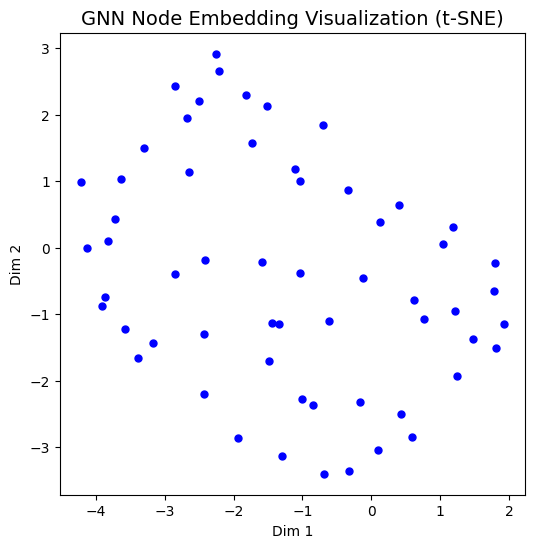

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

model_gnn.eval()

# Pick 1 graph from test set
img, label = test_dataset[0]
graph = image_to_graph(img).to(device)

# Get raw node embeddings after GNN layers
with torch.no_grad():
    x1 = model_gnn.conv1(graph.x, graph.edge_index)
    x2 = model_gnn.conv2(x1, graph.edge_index)
    embeddings = x2.cpu().numpy()

# t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embeddings)

# plot
plt.figure(figsize=(6, 6))
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c="blue", s=25)
plt.title("GNN Node Embedding Visualization (t-SNE)", fontsize=14)
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.show()


**Comparing CNN vs GNN Predictions (Side-by-Side on the Same Images)**

We randomly select test images and show how both models classify them.
Each image displays the actual label, the CNN’s prediction, and the GNN’s prediction.
This visual comparison helps highlight the strengths and weaknesses of both architectures on the same inputs.

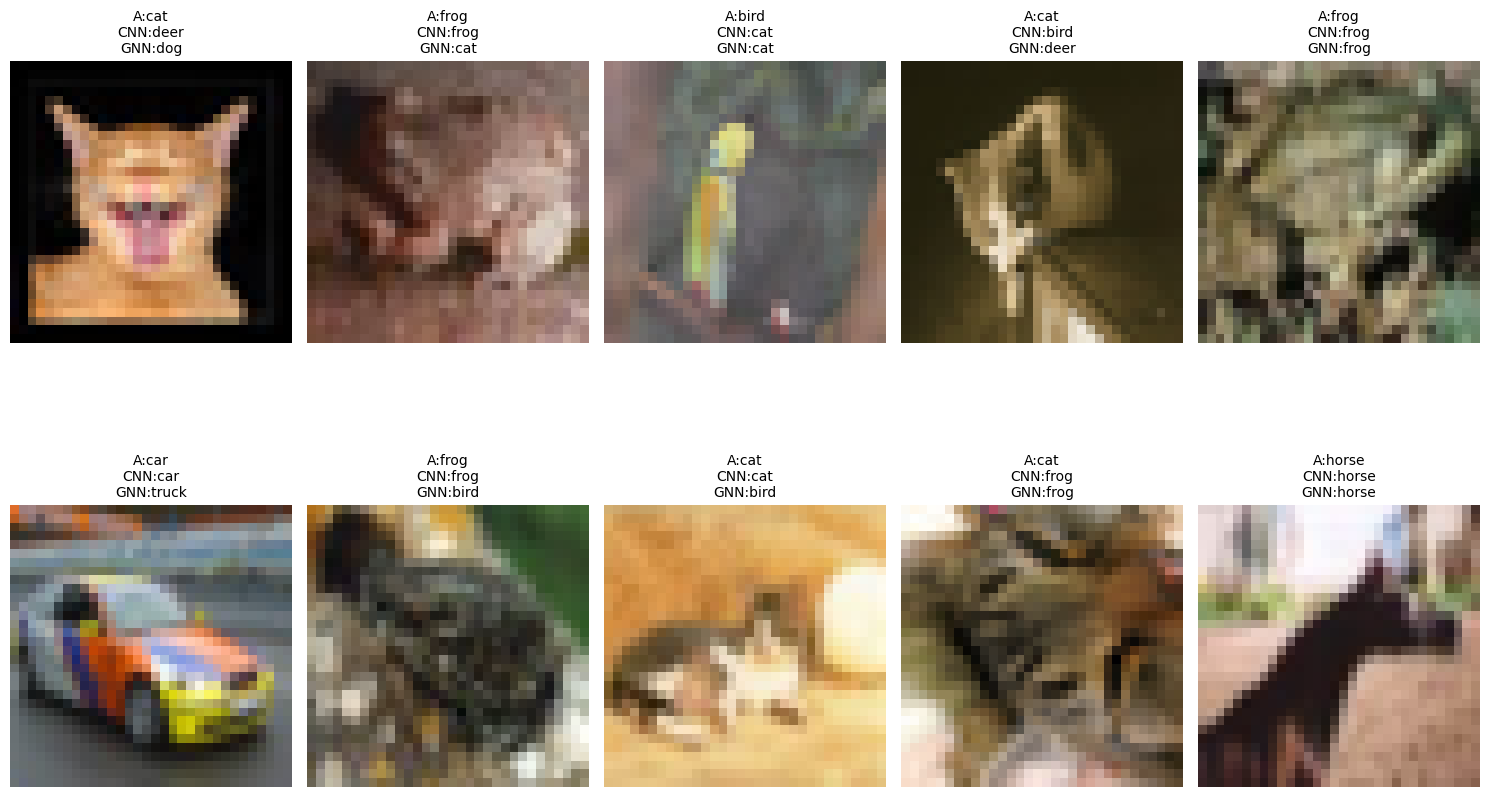

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

def unnormalize(img):
    return (img * 0.5 + 0.5).numpy()

model.eval()
model_gnn.eval()

fig = plt.figure(figsize=(15, 10))

for i in range(10):
    idx = random.randint(0, len(test_dataset) - 1)
    img, label = test_dataset[idx]

    # --- CNN PREDICTION ---
    cnn_out = model(img.unsqueeze(0).to(device))
    _, cnn_pred = cnn_out.max(1)
    cnn_pred = cnn_pred.item()

    # --- GNN PREDICTION ---
    graph = image_to_graph(img)
    graph.y = torch.tensor([label])
    graph = graph.to(device)

    with torch.no_grad():
        gnn_out = model_gnn(
            graph.x,
            graph.edge_index,
            torch.zeros(graph.x.size(0), dtype=torch.long).to(device)
        )
        _, gnn_pred = gnn_out.max(1)
        gnn_pred = gnn_pred.item()

    # --- Plot image ---
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(np.transpose(unnormalize(img), (1, 2, 0)))
    ax.set_title(
        f"A:{classes[label]}\nCNN:{classes[cnn_pred]}\nGNN:{classes[gnn_pred]}",
        fontsize=10
    )
    ax.axis("off")

plt.tight_layout()
plt.show()


**Graph Visualization (Superpixels → Graph Structure)**

This section visualizes how an image is converted into a graph for the GNN model.
First, we apply SLIC to divide the image into ~75 superpixels.
Then, each superpixel becomes a graph node, and edges are created between adjacent regions.
The first plot shows the superpixel boundaries on the original image, and the second plot shows the corresponding graph structure used by the GNN.

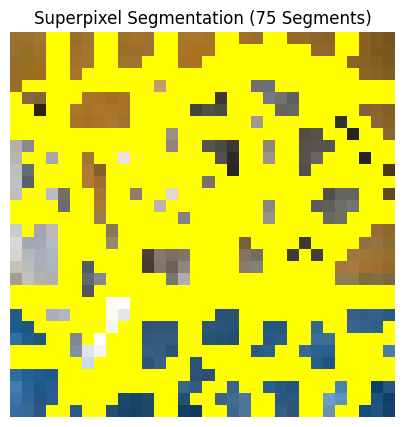

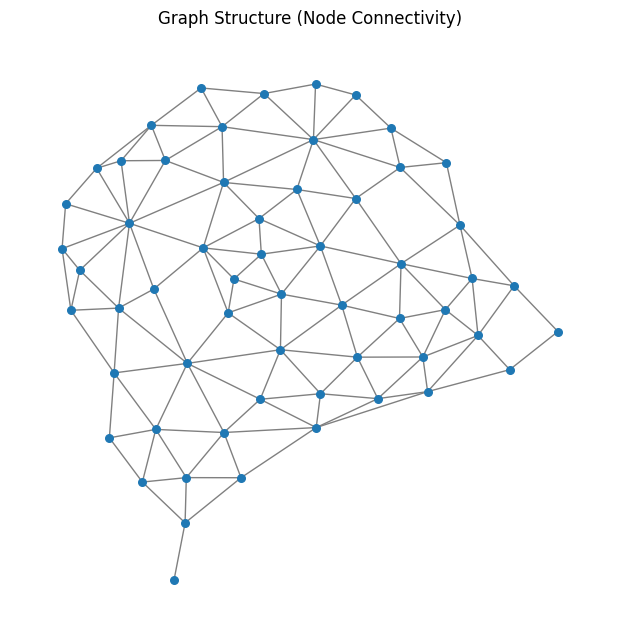

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from skimage.segmentation import mark_boundaries

# Pick a random test image
img, label = test_dataset[0]

# Perform superpixel segmentation
img_np = (img * 0.5 + 0.5).permute(1,2,0).numpy()
segments = slic(img_np, n_segments=75, compactness=10, start_label=0)

# Show superpixels on image
plt.figure(figsize=(5,5))
plt.imshow(mark_boundaries(img_np, segments))
plt.title("Superpixel Segmentation (75 Segments)")
plt.axis("off")
plt.show()

# Build graph
graph = image_to_graph(img)

# Create networkx graph for visualization
G = nx.Graph()
edge_index = graph.edge_index.cpu().numpy()

# Add edges
for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0, i], edge_index[1, i])

# Plot graph alone (without background)
plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=30, edge_color='gray')
plt.title("Graph Structure (Node Connectivity)")
plt.show()


**Measuring Inference Time: CNN vs GNN**

To compare computational efficiency, we measure how long each model takes to make a single prediction.
Both the CNN and GNN run 100 forward passes, and we compute the average time per image.
This highlights the speed difference between grid-based convolution (CNN) and graph-based message passing (GNN).

In [ ]:
import time

# ---- CNN Inference Time ----
img, _ = test_dataset[0]
img = img.unsqueeze(0).to(device)

start = time.time()
with torch.no_grad():
    for _ in range(100):
        model(img)
end = time.time()

cnn_time = (end - start) / 100
print("CNN Inference Time (per image):", cnn_time, "sec")


# ---- GNN Inference Time ----
graph = image_to_graph(test_dataset[0][0]).to(device)
batch_vec = torch.zeros(graph.x.size(0), dtype=torch.long).to(device)

start = time.time()
with torch.no_grad():
    for _ in range(100):
        model_gnn(graph.x, graph.edge_index, batch_vec)
end = time.time()

gnn_time = (end - start) / 100
print("GNN Inference Time (per image):", gnn_time, "sec")


CNN Inference Time (per image): 0.0004986166954040527 sec
GNN Inference Time (per image): 0.0025749993324279785 sec
